In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed
import unittest

In [7]:
class Lagger:
    def __init__(self, beta=2, sigma=4):
        self.beta = beta
        self.sigma = sigma

    def lagger(self, t, n):
        if self.beta < 0 or self.beta > self.sigma:
            raise ValueError("Wrong parameters")

        lpp = np.sqrt(self.sigma)*np.exp(-self.beta*t/2)
        lp = np.sqrt(self.sigma)*(1 - self.sigma*t)*np.exp(-self.beta*t/2)

        if n == 0:
            return lpp
        if n == 1:
            return lp

        for i in range(2, n+1):
            temp = lp
            lp = (2*i - 1 - self.sigma*t)*lp/i - (i-1)*lpp / i
            lpp = temp

        return lp

    def tabulate_lagger(self, T, n):
        t = np.linspace(1, T, T)
        results = [self.lagger(ti, n) for ti in t]
        df = pd.DataFrame({'t': t, 'l': results})
        return df.round(4)

    def experiment(self, N, max_T=100, epsilon=0.00001):
        time_samples = np.linspace(0, max_T, 1000)
        lagger_range = range(N + 1)

        for current_time in time_samples:
            conditions_met = all(
                abs(self.lagger(current_time, index)) < epsilon
                for index in lagger_range
            )

            if conditions_met:
                return current_time

        raise ValueError("The analysis failed. No suitable time (T) found. Consider increasing the max time (max_T).")

    def tabulate_experiment(self, N, max_T=100, epsilon=0.001):
        t = self.experiment(N, max_T, epsilon)

        lt_values = [self.lagger(t, n) for n in range(N + 1)]

        data = {
            "t": [t] * (N + 1),
            "n": list(range(N + 1)),
            "L(t)": lt_values
        }

        return pd.DataFrame(data).round(4)

    def integral(self, f, a, b, margin=0.001):
        area = 0
        current_point = a + margin / 2

        while current_point < b:
            area += margin * f(current_point)
            current_point += margin

        return area

    def lagger_transformation(self, f, N, epsilon=0.001):
        to = self.experiment(N)

        transformed_values = [
            self.integral(lambda t: f(t) * self.lagger(t, k) * np.exp(-t * (self.sigma - self.beta)), 0, to, epsilon)
            for k in range(N + 1)
        ]

        return transformed_values

    def tabulate_lagger_transform(self, f, n, epsilon=0.001):
        transformed = self.lagger_transformation(f, n, epsilon)
        cols = {"n": range(0, n+1), "transformed": transformed}
        print(pd.DataFrame(cols).round(4))
        

    def draw_lagger(self, T, N):
        x = np.arange(0, T + 1, 0.01)

        fig, ax = plt.subplots()
        ax.set_title('Laguerre polynomials $L_n$')

        for n in range(N + 1):
            ax.plot(x, self.lagger(x, n), label=rf'$L_{n}$')

        plt.xlabel('t')
        plt.ylabel('L(t)')
        plt.title('Plot of Laguerre function')
        plt.legend()
        plt.grid(True)
        plt.show()

    def draw_rlt(self, f, N, epsilon=0.001):
        transformed_values = self.lagger_transformation(f, N, epsilon)

        def fun(x):
            return self.reverse_lagger_transformation(f, N, x, transformed_values)

        t_values = np.linspace(0, 2 * np.pi, 100)
        f_y_values = np.vectorize(f)(t_values)
        fun_y_values = np.vectorize(fun)(t_values)

        plt.plot(t_values, fun_y_values, label="Reverse Laguerre Transform")
        plt.plot(t_values, f_y_values, label="Original Function")
        plt.xlabel('t')
        plt.ylabel('Function Value')
        plt.title('Plot of Reverse Laguerre Transformed Function')
        plt.legend()
        plt.grid(True)
        plt.show()

    def reverse_lagger_transformation(self, f, N, t, transformed):
        sum = 0
        for k in range(N):
            sum += transformed[k] * self.lagger(t, k)
        return sum

In [19]:
class TestLaggere(unittest.TestCase):
    def setUp(self):
        self.lagger = Lagger()

    def test_lagger(self):
        result = self.lagger.lagger(0, 0)
        self.assertAlmostEqual(result, 1)

        result = self.lagger.lagger(0, 1)
        self.assertAlmostEqual(result, 0)

        result = self.lagger.lagger(1, 1)
        self.assertAlmostEqual(result, np.sqrt(self.lagger.sigma) * (1 - self.lagger.sigma))

    def test_experiment(self):
        result = self.lagger.experiment(5)
        self.assertTrue(result > 0)

    def test_lagger_transformation(self):
        result = self.lagger.lagger_transformation(lambda x: x**2, 5)
        self.assertEqual(len(result), 6)

    def test_reverse_lagger_transformation(self):
        f = lambda x: x**2
        transformed_values = self.lagger.lagger_transformation(f, 5)
        result = self.lagger.reverse_lagger_transformation(f, 5, np.pi, transformed_values)
        expected_result = np.pi**2
        self.assertAlmostEqual(result, expected_result, places=5)

In [9]:
lagger = Lagger()

In [10]:
def fun(t):
    if 0 <= t <= 2 * np.pi:
        return np.cos(t + 2 * np.pi / 3)
    elif t > 2 * np.pi:
        return 1
    else:
        raise ValueError("Incorrect t")

In [11]:
def function(t):
    if t >= 0 and t <= 2*np.pi:
        return np.sin(t-np.pi/2) + 1
    else:
        return 0

In [12]:
lagger.tabulate_lagger(5,5)

,t,l
0,1.0,-0.6377
1,2.0,2.1473
2,3.0,2.7283
3,4.0,-26.0253
4,5.0,-64.2216


In [13]:
lagger.tabulate_experiment(20)

,t,n,L(t)
0,79.0791,0,0.0000
1,79.0791,1,-0.0000
2,79.0791,2,0.0000
3,79.0791,3,-0.0000
4,79.0791,4,0.0000
5,79.0791,5,-0.0000
6,79.0791,6,0.0000
7,79.0791,7,-0.0000
8,79.0791,8,0.0000
9,79.0791,9,-0.0000


In [14]:
lagger.tabulate_lagger_transform(function, 10)

     n  transformed
0    0       0.0667
1    1      -0.1822
2    2       0.1781
3    3      -0.0743
4    4       0.0073
5    5       0.0076
6    6      -0.0031
7    7      -0.0006
8    8       0.0008
9    9      -0.0000
10  10      -0.0002


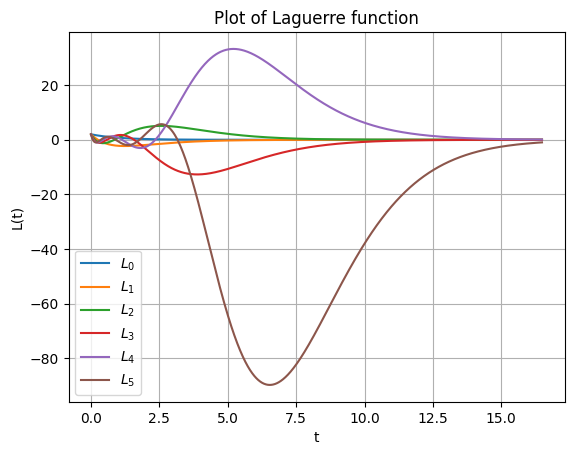

In [15]:
lagger.draw_lagger(15.5,5)

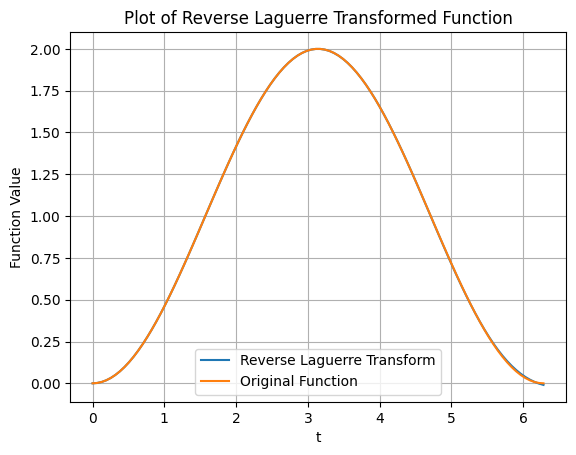

In [16]:
lagger.draw_rlt(function, 20)

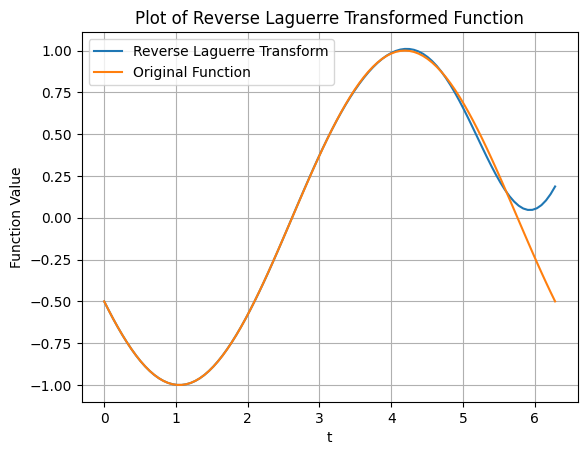

In [17]:
lagger.draw_rlt(fun, 20)

In [20]:
unittest.main(argv=[''], exit=False)

.F.F
FAIL: test_lagger (__main__.TestLaggere.test_lagger)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "C:\Users\smola\AppData\Local\Temp\ipykernel_18660\3117910118.py", line 7, in test_lagger
    self.assertAlmostEqual(result, 1)
AssertionError: 2.0 != 1 within 7 places (1.0 difference)

FAIL: test_reverse_lagger_transformation (__main__.TestLaggere.test_reverse_lagger_transformation)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "C:\Users\smola\AppData\Local\Temp\ipykernel_18660\3117910118.py", line 28, in test_reverse_lagger_transformation
    self.assertAlmostEqual(result, expected_result, places=5)
AssertionError: 10.417374637019464 != 9.869604401089358 within 5 places (0.5477702359301055 difference)

----------------------------------------------------------------------
Ran 4 tests in 2.830s

FAILED (failures=2)
